In [2]:
import cv2
import numpy as np
import tensorflow as tf


def loadData(split_rate=0.8):
    def parse_files(x_fname, y_fname):
        image_string = tf.io.read_file(x_fname)
        image_decoded = tf.image.decode_jpeg(image_string, channels=3)
        x = tf.cast(image_decoded, tf.float32) / 127.5 - 1

        image_string = tf.io.read_file(y_fname)
        image_decoded = tf.image.decode_jpeg(image_string, channels=1)
        y = tf.cast(image_decoded, tf.float32) / 255.0

        return x, y

    x = tf.data.Dataset.list_files('./dataset/x/*.jpg', shuffle=False)
    x = list(x.as_numpy_iterator())

    y = tf.data.Dataset.list_files('./dataset/y/*.jpg', shuffle=False)
    y = list(y.as_numpy_iterator())

    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.shuffle(buffer_size=len(x), seed=123).map(parse_files)
    # ds = ds.prefetch(buffer_size=8)
    print('data size: ' + str(len(x)))

    spliter = int(len(x) * split_rate)
    ds_train = ds.take(spliter)
    ds_test = ds.skip(spliter)
    return ds_train, ds_test


def create_model():
    base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, input_shape=(None, None, 3))
    base_model.trainable = False
    base_model.summary()

    input = base_model.input
    hx = base_model.layers[56].output  # VGG:9, MobilenetV2:26
    output = tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=8*2, strides=8, padding='same')(hx)

    model = tf.keras.Model(inputs=input, outputs=output)
    model.summary()

    opt_fn = tf.keras.optimizers.Adam(0.01)
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    model.compile(optimizer=opt_fn, loss=loss_fn)
    return model


def train_model(model, ds_train, ds_test=None, initial_epoch=0, epochs=50, batchSize=64):
    board_cb = tf.keras.callbacks.TensorBoard(
        log_dir='./tf_board',
        histogram_freq=0,  # How often to log histogram visualizations
        embeddings_freq=1,  # How often to log embedding visualizations
        update_freq="epoch",
    )

    final_epoch = initial_epoch+epochs
    for e in range(initial_epoch, final_epoch):
        x = ds_train.batch(batchSize)
        model.fit(x=x, epochs=e+1, initial_epoch=e,
                #   callbacks=[board_cb], # board_cb,
                  # validation_data=ds_test,
                  # validation_freq=1,
                  verbose=1)

        print('start training ...')


ds_train, _ = loadData(split_rate=0.1)
model = create_model()
model.trainable = False
train_model(model, ds_train, initial_epoch=0, epochs=4, batchSize=16)
model.trainable = True
train_model(model, ds_train, initial_epoch=0, epochs=10, batchSize=16)



data size: 5000
9420800/9406464 [==============================] - 3s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, None, None, 3 0           bn_Conv1[0][0]                   


block_10_expand_relu (ReLU)     (None, None, None, 3 0           block_10_expand_BN[0][0]         
__________________________________________________________________________________________________
block_10_depthwise (DepthwiseCo (None, None, None, 3 3456        block_10_expand_relu[0][0]       
__________________________________________________________________________________________________
block_10_depthwise_BN (BatchNor (None, None, None, 3 1536        block_10_depthwise[0][0]         
__________________________________________________________________________________________________
block_10_depthwise_relu (ReLU)  (None, None, None, 3 0           block_10_depthwise_BN[0][0]      
__________________________________________________________________________________________________
block_10_project (Conv2D)       (None, None, None, 9 36864       block_10_depthwise_relu[0][0]    
__________________________________________________________________________________________________
block_10_p

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, None, None, 3 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

32/32 [==============================] - 46s 1s/step - loss: 0.1552
start training ...
Epoch 2/2
32/32 [==============================] - 45s 1s/step - loss: 0.0292
start training ...
Epoch 3/3
32/32 [==============================] - 42s 1s/step - loss: 0.0206
start training ...
Epoch 4/4
32/32 [==============================] - 43s 1s/step - loss: 0.0188
start training ...
32/32 [==============================] - 43s 1s/step - loss: 0.0182
start training ...
Epoch 2/2
32/32 [==============================] - 43s 1s/step - loss: 0.0170
start training ...
Epoch 3/3
32/32 [==============================] - 42s 1s/step - loss: 0.0169
start training ...
Epoch 4/4
32/32 [==============================] - 43s 1s/step - loss: 0.0163
start training ...
Epoch 5/5
 7/32 [=====>........................] - ETA: 35s - loss: 0.0162

KeyboardInterrupt: 

255

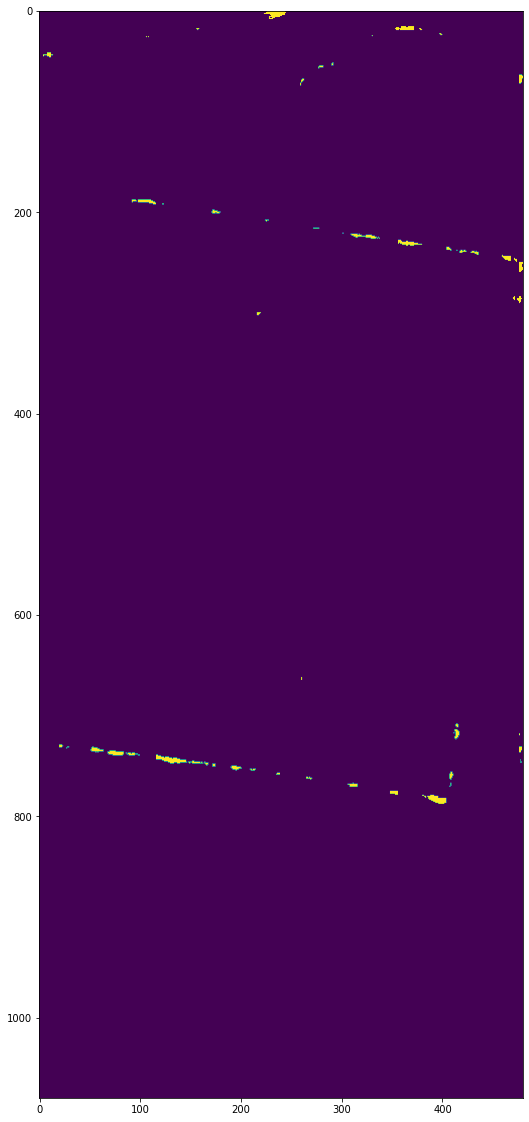

In [7]:
import matplotlib.pyplot as plt

# image_string = tf.io.read_file('./dataset/x/3000.jpg')
image_string = tf.io.read_file('./a.jpg')
image_decoded = tf.image.decode_jpeg(image_string, channels=3)
test = tf.image.resize(image_decoded, (1080, 1080), preserve_aspect_ratio=True)
test = tf.cast(test, tf.float32) / 127.5 - 1
test = tf.reshape(test, (1)+test.shape)
p = model.predict(test)[0, :, :, :]
# min, max = np.min(p), np.max(p)
# p = (p-min) / (max-min)
p = p > 0.5
img = p  * 255
cv2.imwrite("./result.jpg", img)
plt.figure(figsize = (20,20))
plt.imshow(img)

np.max(img)


In [ ]:
import tensorflow as tf
filePath = './Models/edge_detector_MobileNetV2.h5'
model.save(filePath, overwrite=True, include_optimizer=False)


In [8]:
import tensorflow as tf
filePath = './Models/edge_detector_MobileNetV2.h5'
model = tf.keras.models.load_model(filePath)



OSError: SavedModel file does not exist at: ./Models/edge_detector_MobileNetV2.h5/{saved_model.pbtxt|saved_model.pb}

In [ ]:
import tensorflow as tf
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False, input_shape=(512, 512, 3))
count =0
for l in base_model.layers:
    print(count, l.output.shape, l.name)
    count += 1